<a href="https://colab.research.google.com/github/emadaghajanzadeh/Sales_Forecasting_RNN/blob/main/GRU_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recurrent Neural Networks


# GRU on a Time Series


Data source: https://fred.stlouisfed.org/series/S4248SM144NCEN

## Perform standard imports

In [ ]:
#1
# $$$ imports
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


## Load the dataset
We'll take advantage of pandas' built-in <a href='https://pandas.pydata.org/pandas-docs/stable/timeseries.html'>DatetimeIndex</a> by passing <tt>parse_dates=True</tt>

In [ ]:
#2
# $$$ read csv
df = pd.read_csv('./A_Sales.csv',index_col=0 ,parse_dates=True)
df

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174


In [ ]:
#3
# $$$ drop unreadable values with df.dropna
# Always a good idea with time series data:
df = df.dropna()
df

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174


## Plotting time series data
We can add titles, axis labels, and other features to the plot.<br>
We're going to tighten the x-axis to fit the width of the actual data with <tt>plt.autoscale(axis='x',tight=True)</tt>.<br>
Alternatively you could set your own limits with <tt>plt.xlim(pd.Timestamp('1992-01-01'), pd.Timestamp('2019-01-01'))</tt> or some other values.

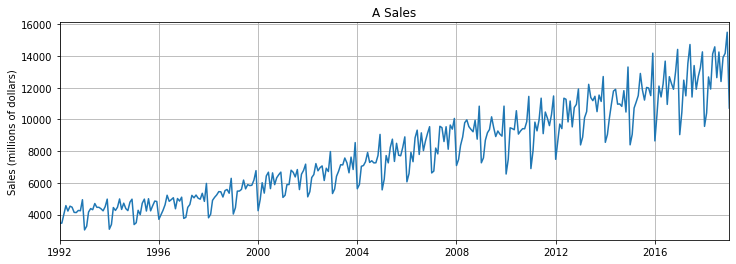

In [ ]:
#4
# $$$ plot data
plt.figure(figsize=(12,4))
plt.title('A Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
# plt.xlim(pd.Timestamp('1992-01-01'), pd.Timestamp('2019-01-01'))
plt.show()

## Prepare the data
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [ ]:
#5
# $$$ split train and test
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)
test = y[-12:]
train = y[:-12]
# print(train)
# print(test)


[ 3459.  3458.  4002.  4564.  4221.  4529.  4466.  4137.  4126.  4259.
  4240.  4936.  3031.  3261.  4160.  4377.  4307.  4696.  4458.  4457.
  4364.  4236.  4500.  4974.  3075.  3377.  4443.  4261.  4460.  4985.
  4324.  4719.  4374.  4248.  4784.  4971.  3370.  3484.  4269.  3994.
  4715.  4974.  4223.  5000.  4235.  4554.  4851.  4826.  3699.  3983.
  4262.  4619.  5219.  4836.  4941.  5062.  4365.  5012.  4850.  5097.
  3758.  3825.  4454.  4635.  5210.  5057.  5231.  5034.  4970.  5342.
  4831.  5965.  3796.  4019.  4898.  5090.  5237.  5447.  5435.  5107.
  5515.  5583.  5346.  6286.  4032.  4435.  5479.  5483.  5587.  6176.
  5621.  5889.  5828.  5849.  6180.  6771.  4243.  4952.  6008.  5353.
  6435.  6673.  5636.  6630.  5887.  6322.  6520.  6678.  5082.  5216.
  5893.  5894.  6799.  6667.  6374.  6840.  5575.  6545.  6789.  7180.
  5117.  5442.  6337.  6525.  7216.  6761.  6958.  7070.  6148.  6924.
  6716.  7975.  5326.  5609.  6414.  6741.  7144.  7133.  7568.  7266.
  6634

It's worth noting that in our previous exercise the train and test sets were tensors. Here they're numpy arrays. This is because one of the steps we're about to perform outputs an array, and we'd have to turn it into a tensor anyway.

## Normalize the data
The formula for normalizing data around zero is:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the population mean, and $\sigma$ is the population standard deviation.<br>
Recall that back in the CNN section we transformed image files using <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt><strong>torchvision.transforms.Normalize(<em>mean, std</em>)</strong></tt></a>, both because it was built into DataLoader, and because our pretrained models expected specific normalization values.<br>

Ultimately we want to perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> so that our values fall between -1 and 1, as this makes hyperparameters converge faster.<br>The formula for this would be:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$<br>

We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

NOTE: We only want to normalize the training set to avoid data leakage. If we include the test set then the higher average values of the test set could become part of the signal in the training set. There's a good article on data leakage <a href='test_set = input_data(test_norm,window_size)'>here</a>.

After using transformed data to train the model and generate predictions, we'll inverse_transform the predicted values so that we can compare them to the actual test data.

In [ ]:
#6
# $$$ scale data (-1 , 1)
from sklearn.preprocessing import MinMaxScaler
train = train.reshape(-1,1)
scaler=MinMaxScaler(feature_range=(-1,1))
train_norm=scaler.fit_transform(train)
# y_train

## Prepare data for GRU
Here we'll create our list of (seq/label) tuples from the training set. Recall that an GRU consumes a window of samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [ ]:
#7
# $$$ prepare data with input_data function (tuple)
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12


301

## Define the model
This time we'll use an GRU layer of size (1,100).

In [ ]:
#8
# $$$ create GRU class
# nn.GRU
# nn.Linear


class GRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
      super().__init__()
      self.hidden_layer = (torch.zeros(hidden_size))
      self.GRU_layer = nn.GRU(input_size,hidden_size)
      self.FC = nn.Linear(hidden_size,output_size)
      self.hidden_size = hidden_size
      
    def forward(self,data):
      data = data.view(len(data),1,-1)
      output, self.hidden_layer = self.GRU_layer(data, self.hidden_layer)
      output = output.view(len(data),-1)
      output = self.FC(output)
      return output[-1]


## Instantiate the model, define loss and optimization functions

In [ ]:
#9
# $$$ set seed, criterion, optimizer
torch.manual_seed(101)
model = GRU(1,100,1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



## Train the model

In [ ]:
#10
# $$$ train the model
import time
startTrain = time.time()
epochs = 20

for epoch in range(epochs):
    for data, target in train_data:       
        optimizer.zero_grad()
        model.hidden_layer = (torch.zeros(1,1,model.hidden_size))
        prediction = model(data)

        loss = criterion(prediction, target)
        loss.backward()
        optimizer.step()
        
    print(f'epoch:{epoch+1:2}  Loss is: {loss.item():5.10f}')
    
print(f'\nTrain Duration: {time.time() - startTrain:.5f} seconds')



epoch: 1  Loss is: 0.3163814545
epoch: 2  Loss is: 0.3656209707
epoch: 3  Loss is: 0.3778117895
epoch: 4  Loss is: 0.3536266685
epoch: 5  Loss is: 0.3294491172
epoch: 6  Loss is: 0.3452953398
epoch: 7  Loss is: 0.2791855931
epoch: 8  Loss is: 0.1304776520
epoch: 9  Loss is: 0.0406643301
epoch:10  Loss is: 0.0029299161
epoch:11  Loss is: 0.0008059797
epoch:12  Loss is: 0.0043481621
epoch:13  Loss is: 0.0002977171
epoch:14  Loss is: 0.0000113536
epoch:15  Loss is: 0.0002035459
epoch:16  Loss is: 0.0003980906
epoch:17  Loss is: 0.0005083457
epoch:18  Loss is: 0.0005187883
epoch:19  Loss is: 0.0004380552
epoch:20  Loss is: 0.0002943441

Train Duration: 31.00935 seconds


## Run predictions and compare to known test set

In [ ]:
#11
# $$$ predict test segment
future = 12
test_prediction = train_norm[-window_size:].tolist()
model.eval()
for i in range(future):
    data = torch.FloatTensor(test_prediction[-window_size:])
    with torch.no_grad():
        test_prediction.append(model(data).item())


## Invert the normalization
We want to compare our test predictions to the original data, so we need to undo the previous normalization step. Note that <tt>inverse_transform</tt> uses the most recently applied parameters; we can rescale based on the test data, but not on the previous training data.

In [ ]:
#12
# invert normalization to plot test
true_predictions = scaler.inverse_transform(np.array(test_prediction).reshape(-1, 1))

It looks like our predictions weren't that far off!
## Plot the results
Our original data contains a datetime index, but our predicted values do not. We can create a range of dates using NumPy that are spaced one month apart using <tt>dtype='datetime64[M]'</tt>, and then store them with day values to match our dataset with <tt>.astype('datetime64[D]')</tt>.

In [ ]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2019-01-01', '2020-01-01', dtype='datetime64[M]').astype('datetime64[D]') 
x

array(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
       '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
       '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
      dtype='datetime64[D]')

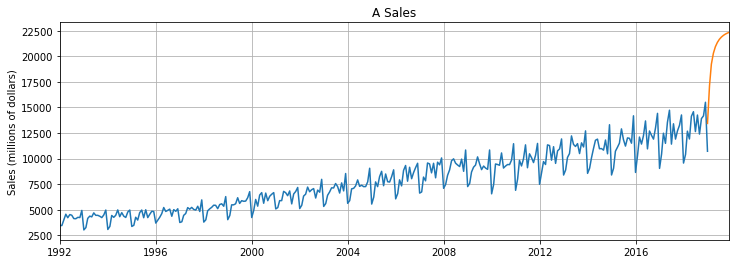

In [ ]:
plt.figure(figsize=(12,4))
plt.title('A Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()

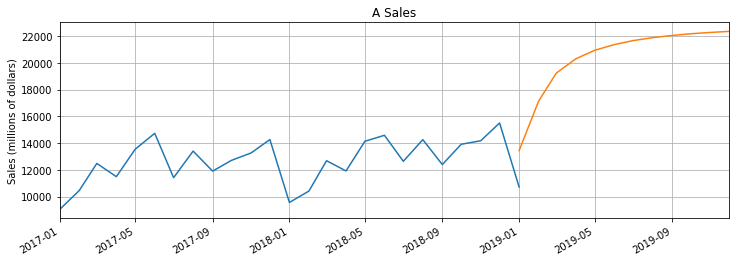

In [ ]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('A Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions[window_size:])
plt.show()